# Regression Analysis for Payment Time Prediction

Regression analysis to predict the time it takes for invoices to be paid using the `payments_master.csv` dataset. The goal is to understand factors influencing payment duration and to test the hypothesis that all invoices take approximately the same time (±1 day) to be paid.


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 1. Data Loading and Preparation

First, we load the `payments_master.csv` dataset and perform initial data cleaning and feature engineering. We convert relevant date columns to datetime objects and calculate the `time_to_payment` in days, which will be our target variable. Rows with missing `time_to_payment` values are dropped.


In [8]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')
print(f"Data directory is set to: {data_dir}")

payment_master_path = os.path.join(data_dir, 'payments_master.csv')
fraud_case_master_path = os.path.join(data_dir, 'fraud_case_master.csv')
research_team_master_path = os.path.join(data_dir, 'research_team_master.csv')
research_team_member_master_path = os.path.join(data_dir, 'research_team_member_master.csv')
print("************************\n")
print(f"Payment master path: {payment_master_path}")
print(f"Fraud case master path: {fraud_case_master_path}")
print(f"Research team master path: {research_team_master_path}")
print(f"Research team member master path: {research_team_member_master_path}")


Data directory is set to: c:\Users\homep\Documents\Projects\bupa_case_study\data
************************

Payment master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\payments_master.csv
Fraud case master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\fraud_case_master.csv
Research team master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_master.csv
Research team member master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_member_master.csv


In [9]:
# Load the dataset
try:
    df = pd.read_csv(payment_master_path)
except FileNotFoundError:
    print("Error: payments_master.csv not found. Please ensure the file is in the correct directory.")
    exit()

# Convert date columns to datetime objects
date_cols = ['Date received', 'Date of invoice', 'Date of authorisation', 'Payment due date', 'Date of payment']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate 'time to payment' in days
df['time_to_payment'] = (df['Date of payment'] - df['Date received']).dt.days

# Drop rows where 'time_to_payment' is NaN (due to missing date of payment or date received)
df.dropna(subset=['time_to_payment'], inplace=True)

print(f"Dataset loaded with {len(df)} records after dropping rows with missing time_to_payment.")
print(df.head())


Dataset loaded with 1428 records after dropping rows with missing time_to_payment.
  Date received Research team        Submitted by Date of invoice  \
0    2025-04-27      Genetics       Melinda White      2025-04-14   
1    2025-06-02    Immunology     Daniel Peterson      2025-05-28   
3    2025-04-10      Oncology  Christopher Wilson      2025-03-27   
4    2025-05-18    Immunology      Amanda Johnson      2025-05-11   
5    2025-02-02    Immunology        Austin Terry      2025-01-22   

  Invoice number                               Description of spend  \
0      INV-76915  "Procured DNA extraction kits for isolating hi...   
1      INV-64102  "Purchase of endotoxin-free reagents for in vi...   
3      INV-20676  "Procured RNA extraction kits for high-through...   
4      INV-49709  "Purchased Luminex multiplex assay kits for si...   
5      INV-95698  "Procured reagents for intracellular cytokine ...   

   Invoice value Date of authorisation     Authorised by Payment due date  

## 2. Feature Selection and Data Preprocessing

We select relevant features for our regression model, including numerical features like 'Invoice value' and 'Payment amount', and categorical features such as 'Research team', 'Type of expense', and 'Company'. The target variable is `time_to_payment`.

To prepare the data for the model, we use `ColumnTransformer` within a `Pipeline`:
*   **Numerical features** are scaled using `StandardScaler`.
*   **Categorical features** are one-hot encoded using `OneHotEncoder`.


In [10]:
# Select features and target
features = ['Invoice value', 'Payment amount', 'Research team', 'Type of expense', 'Company']
target = 'time_to_payment'

X = df[features]
y = df[target]

# Identify categorical and numerical features
categorical_features = ['Research team', 'Type of expense', 'Company']
numerical_features = ['Invoice value', 'Payment amount']

# Preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Data split into training and testing sets.
X_train shape: (1142, 5), y_train shape: (1142,)
X_test shape: (286, 5), y_test shape: (286,)


## 3. Model Training and Evaluation

We define a `Pipeline` that first applies the preprocessing steps and then trains a `LinearRegression` model. The model is trained on the training data, and then predictions are made on the test set. Finally, we evaluate the model using Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2).

We also test the hypothesis: "All invoices take ~same time ±1 day." This is checked by comparing the MAE to 1 day.


In [11]:
# Define the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Hypothesis testing (simple check based on MAE)
if mae <= 1:
    print("\nThe model supports the hypothesis: Invoices take approximately the same time (within +/- 1 day).")
else:
    print(f"\nThe model does not strongly support the hypothesis: MAE ({mae:.2f} days) is greater than 1 day.")


Mean Absolute Error (MAE): 6.68
Mean Squared Error (MSE): 64.83
Root Mean Squared Error (RMSE): 8.05
R-squared (R2): -0.19

The model does not strongly support the hypothesis: MAE (6.68 days) is greater than 1 day.


## 4. Visualization

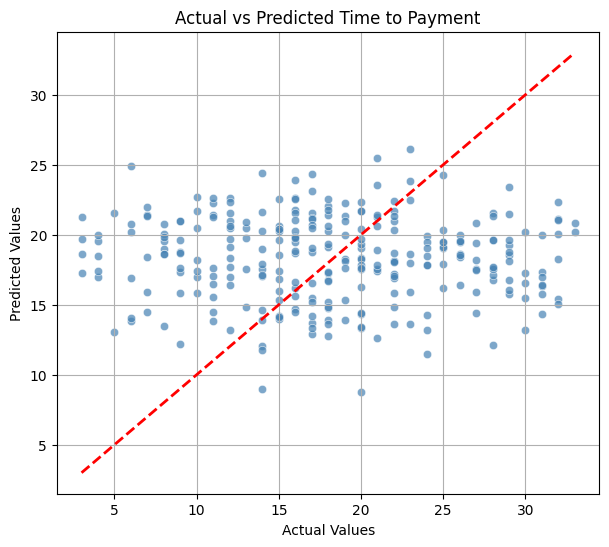

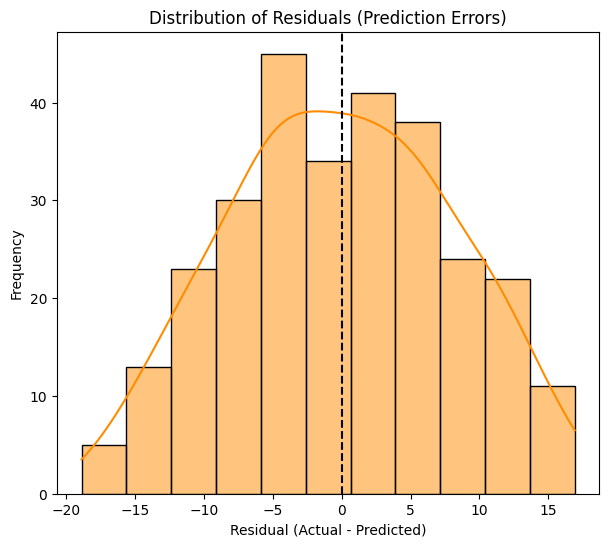

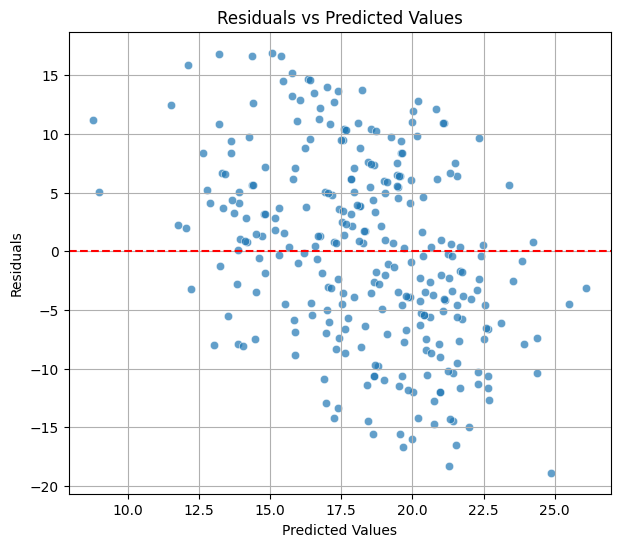

C:\Users\homep\AppData\Local\Temp\ipykernel_16028\1472419889.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')


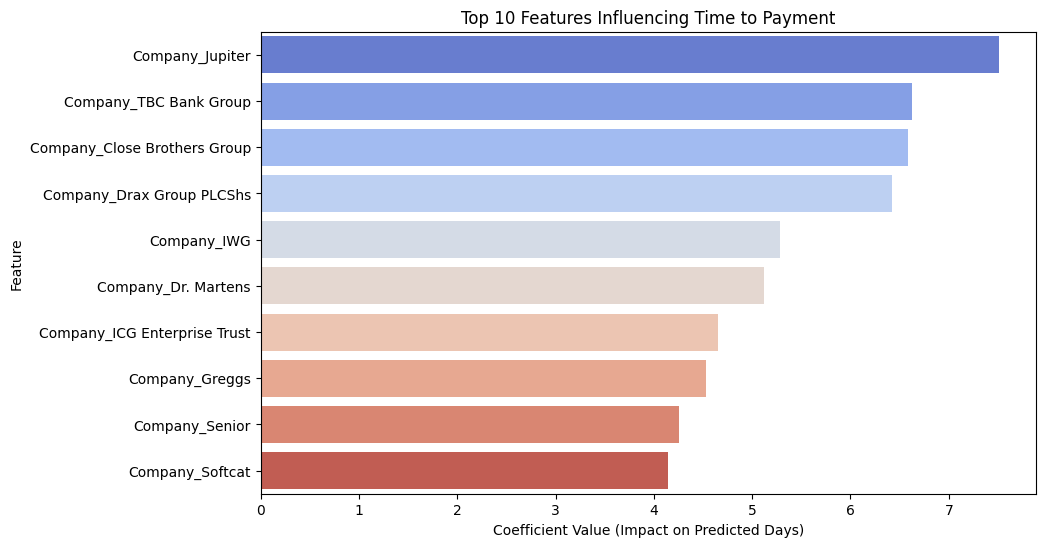

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, color='steelblue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Time to Payment')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.histplot(residuals, kde=True, color='darkorange')
plt.title('Distribution of Residuals (Prediction Errors)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='black', linestyle='--')
plt.show()

# Residuals vs Predicted Values
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Feature Importance (coefficients of linear regression)
# Extract coefficients after preprocessing
coefs = model.named_steps['regressor'].coef_
feature_names = (numerical_features + 
                 list(model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Features Influencing Time to Payment')
plt.xlabel('Coefficient Value (Impact on Predicted Days)')
plt.ylabel('Feature')
plt.show()